In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='12345',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/junaidwar/Desktop/ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as  sns
import mysql.connector

db = mysql.connector.connect(host = "localhost",
                   username ="root",
                   password = "12345",
                   database = "ecommerce")

cur = db.cursor()



<h2># Q1: list all unique cities where customers are loacted.<h2>

<h2># Q2: Count the numbers of orders placed in 2017?<h2>

In [7]:
query =""" select count(order_id) from orders where year(order_purchase_timestamp) =2017 """

cur.execute(query)
data= cur.fetchall()
"total orders placed in 2017 are",data[0][0]


('total orders placed in 2017 are', 90202)

<h4>#Q3: find the total sales per category.<h4>

In [5]:
query =""" select upper(products.product_category) category,
round(sum( payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)
data= cur.fetchall()
df= pd.DataFrame(data,columns=["category","sales"])
df

,category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


<h4> #Q4: calculate the percentage of orders that were paid in installments.<h4>

In [6]:
query =""" select (sum(case when payment_installments >=1 then 1
else 0 end))/count(*)*100 from payments """

cur.execute(query)
data= cur.fetchall()
"the percentage of orders that were paid in installments",data[0][0]

('the percentage of orders that were paid in installments', Decimal('99.9981'))

<h4>Q5: count the number of customers from each state</h4>

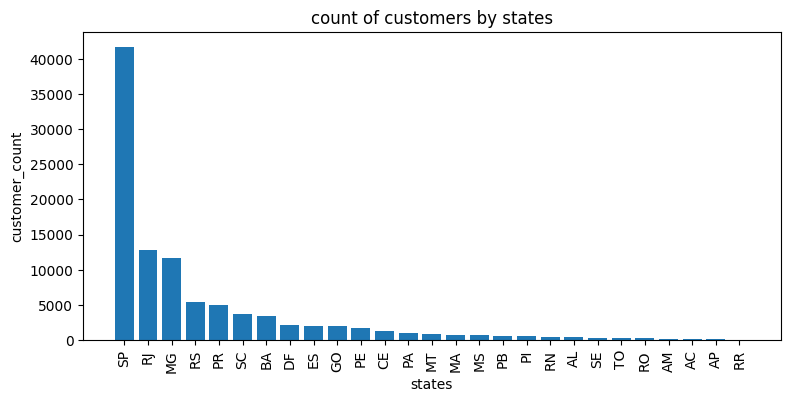

In [16]:
query =""" select customer_state,count(customer_id)
from customers group by customer_state"""

cur.execute(query)
data= cur.fetchall()
df=pd.DataFrame(data,columns=["state","customer_count"])
df= df.sort_values(by ="customer_count",ascending=False)

plt.figure(figsize=(9,4))
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation =90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("count of customers by states")
plt.show()

<h1> intermedate querires</h1>

<h3>Q6: Calculate the number of orders  per month in 2018 </h3>

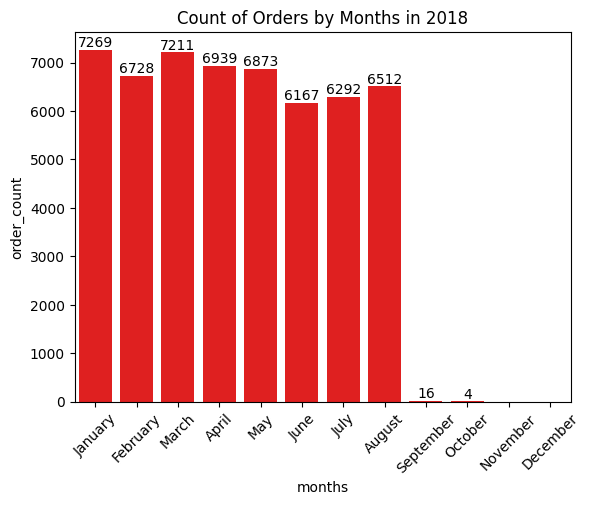

In [20]:
query = """ 
    select monthname(order_purchase_timestamp) months, count(order_id) order_count
    from orders 
    where year(order_purchase_timestamp) = 2018
    group by months
"""


cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["months", "order_count"])


month_order = ["January", "February", "March", "April", "May", "June", 
               "July", "August", "September", "October", "November", "December"]
df["months"] = pd.Categorical(df["months"], categories=month_order, ordered=True)


df.dropna(inplace=True)
ax=sns.barplot(x="months", y="order_count", data=df, order=month_order,color="r")


plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months in 2018")
plt.show()

<h4>Q7:Find the average number of products per order,grouped by customer city</h4>

In [9]:
# if prefer to write the codes in sql ,its more comfortable  (junaid ahmad)
query =""" with count_per_order as
(SELECT orders.order_id , orders.customer_id , count(order_items.order_id)  as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)  

select customers.customer_city,round(avg( count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
 ;
"""

cur.execute(query)
data= cur.fetchall()
data
df= pd.DataFrame(data,columns = ["costomer ciy", "average products per orders"])
df.head(10)

,costomer ciy,average products per orders
0,padre carvalho,14.00
1,celso ramos,13.00
2,datas,12.00
3,candido godoi,12.00
4,matias olimpio,10.00
5,cidelandia,8.00
6,curralinho,8.00
7,picarra,8.00
8,morro de sao paulo,8.00
9,teixeira soares,8.00


<h4>Q8:Calculate the percentage of total revenue contributed by each product category.</h4>

In [6]:
query="""select upper(products.product_category) category,
round((sum( payments.payment_value)/(select  sum(payment_value) from payments))* 100,2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""

cur.execute(query)
data= cur.fetchall()
data

df= pd.DataFrame(data,columns = ["category", "percentage disterbution"])
df.head(10)


,category,percentage disterbution
0,BED TABLE BATH,21.40
1,HEALTH BEAUTY,20.71
2,COMPUTER ACCESSORIES,19.81
3,FURNITURE DECORATION,17.87
4,WATCHES PRESENT,17.86
5,SPORT LEISURE,17.39
6,HOUSEWARES,13.68
7,AUTOMOTIVE,10.65
8,GARDEN TOOLS,10.47
9,COOL STUFF,9.74


<h4>Q9:Identify the correaltion between product price and number of times  a product has been purchased</h4>

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as  sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                   username ="root",
                   password = "12345",
                   database = "ecommerce")

cur = db.cursor()


query="""select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group  by products.product_category """

cur.execute(query)
data= cur.fetchall()

df= pd.DataFrame(data,columns = ["category", "order_count","price"])
arr1 = df["order_count"]
arr2 =df["price"]

a=np.corrcoef([arr1,arr2])
print("the correaltion between  a price and number of times a product has been purchased is", a[0][-1])


the correaltion between  a price and number of times a product has been purchased is -0.10631514167157567


<h4> Q10:Calculate the total revenue geneated by each seller and rank them by revenue.</h4>

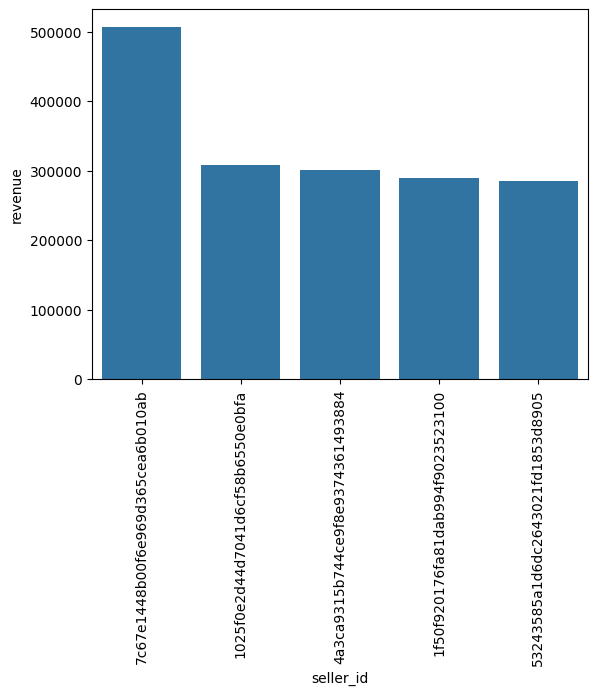

In [5]:
query="""select *, dense_rank() over(order by revenue desc) as rn from
( select order_items.seller_id, sum(payments.payment_value) 
revenue from order_items join payments
on order_items.order_id =payments.order_id
group by order_items.seller_id) as a

"""

cur.execute(query)
data= cur.fetchall()
data
df=pd.DataFrame(data,columns=["seller_id","revenue","rank"] )
df=df.head()
sns.barplot(x ="seller_id", y="revenue", data =df)
plt.xticks(rotation = 90)
plt.show()

<h1> advanced queries</h1>

<h4> Q11: Calculate the moving  averageof order values from each customers over their order history .(imp quest) </h4>

In [12]:
query="""select customer_id,order_purchase_timestamp,payment,
avg(payment) over (partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from 
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id=orders.order_id) as a"""

cur.execute(query)
data= cur.fetchall()

df=pd.DataFrame(data, columns=["customer_id","order_purchase_timestamp","payment","mov_avg"] )
df


,customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
...,...,...,...,...
207767,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
207768,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207769,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207770,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


<h4> Q12:calculate the cumulative sales per month for each year.(another important question)</h4>

In [19]:
                        """cumulative example
                        200  200  (ist day sale = 200)
                        300 500   (2nd day sale is ist day sale+ 2nd day sale  which is 200+300= 500)
                        600 1100  (3rd day sale is 2nd day sale +3rd day sale  which is 500+600=1100)
                        800  1900  (4th day sale is 3nd day sale +4th day sale  which is 1100+800=1900)
                        1000 2900   (5th day sale is 4th day sale +5th day sale  which is 1900+1000=2900)"""

query="""select years , months , payment, sum(payment)
over(order by years, months) cumulative_sales from
(select year(orders.order_purchase_timestamp)as years,
month(orders.order_purchase_timestamp)as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years,months) as a
"""

cur.execute(query)
data= cur.fetchall()

df=pd.DataFrame(data,columns=["years",",moths","payments","cumulative_sales"] )
df






,years,",moths",payments,cumulative_sales
0,2016,9,504.48,504.48
1,2016,10,118180.96,118685.44
2,2016,12,39.24,118724.68
3,2017,1,276976.08,395700.76
4,2017,2,583816.02,979516.78
5,2017,3,899727.20,1879243.98
6,2017,4,835576.06,2714820.04
7,2017,5,1185837.64,3900657.68
8,2017,6,1022552.76,4923210.44
9,2017,7,1184765.84,6107976.28


<h4>Q13:Calculate the year over year growth rate of total sales </h4>

In [25]:
query="""with a as(select year(orders.order_purchase_timestamp)as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)
select years , ((payment - lag( payment,1) over(order by years))/lag(payment,1)over(order by years))*100 from a
"""

cur.execute(query)
data= cur.fetchall()

df=pd.DataFrame(data,columns=["years","yoy % growth"] )#yoy = year over year
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


<h4>Q14:Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purcahse.</h4>

In [2]:
query ="""
with a as(select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id= orders.customer_id
group by customers.customer_id),
b as(select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp >  first_order
and orders.order_purchase_timestamp < date_add(first_order,interval 6 month)
group by a.customer_id)

select 100*(count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id;
"""

cur.execute(query)
data= cur.fetchall()
data
                        #unfortunately there is no orders like this.

[(None,)]

<h4>Q15: Identify the top 3 customers who spent the most money in each year </h4>

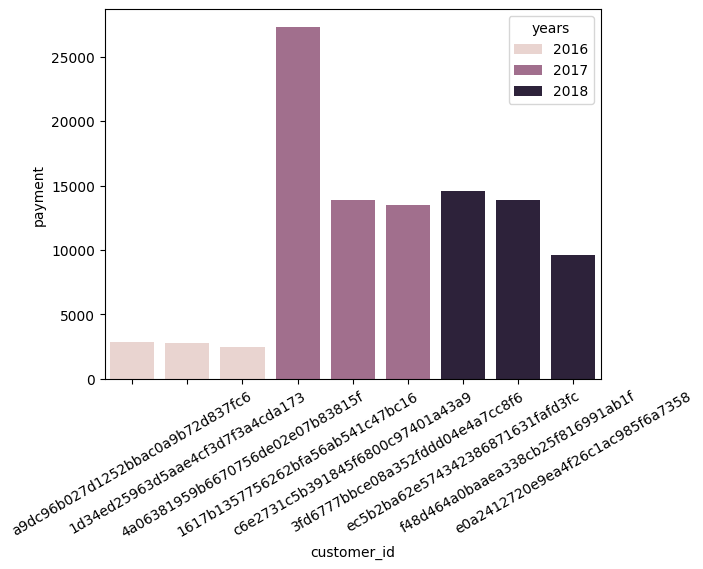

In [13]:
query="""select years, customer_id,payment,d_rank
from 
(select year( orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over (partition by year ( orders.order_purchase_timestamp)
order by sum(payments.payment_value)desc) d_rank
from orders join payments
on payments.order_id =  orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <=3;"""

cur.execute(query)
data= cur.fetchall()
data

df=pd.DataFrame(data,columns=["years","customer_id","payment","rank"] )

sns.barplot(x= "customer_id", y="payment", data= df, hue="years")
plt.xticks(rotation = 30)
plt.show()